# Контекст

- модель RoBERTa
- обучение модели с нуля на наборе текстов
- спец. токены в словаре


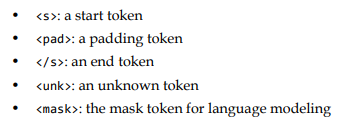

In [14]:
import warnings

from tokenizers import ByteLevelBPETokenizer
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

from transformers import RobertaConfig
from transformers import RobertaTokenizer
from transformers import RobertaForMaskedLM
from transformers import LineByLineTextDataset
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import pipeline

import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")
print('CUDA ?: ', torch.cuda.is_available())

CUDA ?:  True


# Загрузка токенизатора. Первый способ (ручной) - ByteLevelBPETokenizer

Создание токенизатора на основе наших данных а не ранее кем-то загруженных

In [2]:
from tokenizers import ByteLevelBPETokenizer

path = 'kant.txt'
tokenizer = ByteLevelBPETokenizer()

tokenizer.train(
    files = path,
    vocab_size = 52000,
    min_frequency = 2,
    special_tokens = [
        '<s>',
        '<pad>',
        '</s>',
        '<unk>',
        '<mask>'
    ]
)

In [3]:
tokenizer.get_vocab_size()

19296

# Загрузка токенизатора. Второй способ - AutoTokenizer

Загрузка токенизатора GPT-2 (он основан на BPE механизме токенизации)

In [4]:
from transformers import AutoTokenizer

tokenizer2 = AutoTokenizer.from_pretrained('gpt2')

In [5]:
len(tokenizer2.get_vocab())

50257

# Сохранение токенизатора BPE

In [6]:
tokenizer.save_model('my_model/')

['my_model/vocab.json', 'my_model/merges.txt']

# Загрузка токенизатора 

In [7]:
tokenizer = RobertaTokenizer.from_pretrained('my_model/', max_length = 512)
len(tokenizer.get_vocab())

19296

# Инициализация модели с нуля

In [8]:
# задание конфигурации модели
config = RobertaConfig(
    vocab_size = 52000,
    max_position_embeddings = 514,
    num_attention_heads = 12,
    num_hidden_layers = 6,
    type_vocab_size = 1
)


model = RobertaForMaskedLM(config = config)
model

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

# Построение датасета под архитекутуру трансформера

загрузка набора данных построчно для пакетного обучения с block_ size=128, ограничивающим длину примера

In [9]:
dataset = LineByLineTextDataset(
    tokenizer = tokenizer,
    file_path = 'kant.txt',
    block_size = 128
)

# data collator

нужен для маскирования токенов при обучения

In [10]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer = tokenizer,
    mlm = True,
    mlm_probability = 0.15 # маскирует токены с вероятностью 15%
)

# Trainer

In [11]:
training_args = TrainingArguments(
    output_dir = 'my_model/',
    overwrite_output_dir = True,
    num_train_epochs = 1,
    per_device_train_batch_size = 64,
    save_steps = 10000,
    save_total_limit = 2
)

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = dataset
)

# Предварительное обучение модели

In [12]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: oudelexsus2010. Use `wandb login --relogin` to force relogin


  0%|          | 0/2672 [00:00<?, ?it/s]

{'loss': 6.6011, 'grad_norm': 3.2094428539276123, 'learning_rate': 4.06437125748503e-05, 'epoch': 0.19}
{'loss': 5.7332, 'grad_norm': 4.256837844848633, 'learning_rate': 3.12874251497006e-05, 'epoch': 0.37}
{'loss': 5.2735, 'grad_norm': 5.720927715301514, 'learning_rate': 2.1931137724550898e-05, 'epoch': 0.56}
{'loss': 5.0378, 'grad_norm': 5.934671401977539, 'learning_rate': 1.2574850299401197e-05, 'epoch': 0.75}
{'loss': 4.9273, 'grad_norm': 7.240678787231445, 'learning_rate': 3.218562874251497e-06, 'epoch': 0.94}
{'train_runtime': 231.7467, 'train_samples_per_second': 737.719, 'train_steps_per_second': 11.53, 'train_loss': 5.472921588463698, 'epoch': 1.0}


TrainOutput(global_step=2672, training_loss=5.472921588463698, metrics={'train_runtime': 231.7467, 'train_samples_per_second': 737.719, 'train_steps_per_second': 11.53, 'train_loss': 5.472921588463698, 'epoch': 1.0})

# Сохранение модели, токенизатора, конфига

In [13]:
trainer.save_model('my_model/')

# Моделирование языка с помощью pipeline

In [15]:
fill_mask = pipeline(
    task = 'fill-mask', # заполнение токена 
    model = 'my_model/',
    tokenizer = 'my_model/'
)

In [16]:
# При каждом новом запуске - ответу могут меняться
fill_mask("Human thinking involves human <mask>.")

[{'score': 0.021752119064331055,
  'token': 393,
  'token_str': ' reason',
  'sequence': 'Human thinking involves human reason.'},
 {'score': 0.014400044456124306,
  'token': 446,
  'token_str': ' law',
  'sequence': 'Human thinking involves human law.'},
 {'score': 0.009470040909945965,
  'token': 670,
  'token_str': ' principles',
  'sequence': 'Human thinking involves human principles.'},
 {'score': 0.00900216493755579,
  'token': 586,
  'token_str': ' nature',
  'sequence': 'Human thinking involves human nature.'},
 {'score': 0.008309820666909218,
  'token': 418,
  'token_str': ' conception',
  'sequence': 'Human thinking involves human conception.'}]